### Desafio 3
Modelo many to many usando la novela Persuasion de Austen como corpus.


In [ ]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos


In [ ]:
from nltk.corpus import gutenberg
import nltk
nltk.download('gutenberg')
import nltk
nltk.download('punkt')
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
nombres_libros = gutenberg.fileids()
print("Libros disponibles en el corpus de Gutenberg:")
for libro in nombres_libros:
    print(libro)

Libros disponibles en el corpus de Gutenberg:
austen-emma.txt
austen-persuasion.txt
austen-sense.txt
bible-kjv.txt
blake-poems.txt
bryant-stories.txt
burgess-busterbrown.txt
carroll-alice.txt
chesterton-ball.txt
chesterton-brown.txt
chesterton-thursday.txt
edgeworth-parents.txt
melville-moby_dick.txt
milton-paradise.txt
shakespeare-caesar.txt
shakespeare-hamlet.txt
shakespeare-macbeth.txt
whitman-leaves.txt


In [ ]:
book = gutenberg.sents('austen-persuasion.txt')

In [ ]:
len(book)

3747

In [ ]:
# Convierto cada sublista (oración) en una cadena de texto
sents_text = [' '.join(sentence) for sentence in book]

df = pd.DataFrame(sents_text, columns=['Lines'])
df.head()

,Lines
0,[ Persuasion by Jane Austen 1818 ]
1,Chapter 1
2,"Sir Walter Elliot , of Kellynch Hall , in Some..."
3,This was the page at which the favourite volum...
4,""" ELLIOT OF KELLYNCH HALL ."


In [ ]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3747


### Elegir el tamaño del contexto

In [ ]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [ ]:
# cada verso lo guardamos en una lista
text = list(df.iloc[:,0])

In [ ]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [ ]:
text[0]

'[ Persuasion by Jane Austen 1818 ]'

In [ ]:
segmented_sentences[0]

['persuasion', 'by', 'jane', 'austen', '1818']

In [ ]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([1.264e+03, 9.790e+02, 5.470e+02, 3.610e+02, 2.110e+02, 1.470e+02,
        8.700e+01, 5.700e+01, 3.300e+01, 2.100e+01, 1.600e+01, 5.000e+00,
        6.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00]),
 array([  1.  ,  10.65,  20.3 ,  29.95,  39.6 ,  49.25,  58.9 ,  68.55,
         78.2 ,  87.85,  97.5 , 107.15, 116.8 , 126.45, 136.1 , 145.75,
        155.4 , 165.05, 174.7 , 184.35, 194.  ]),
 <BarContainer object of 20 artists>)

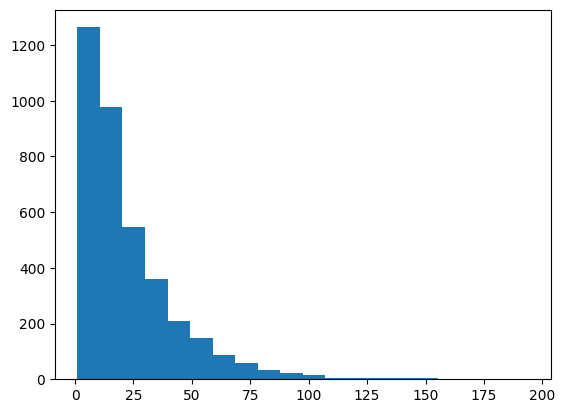

In [ ]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

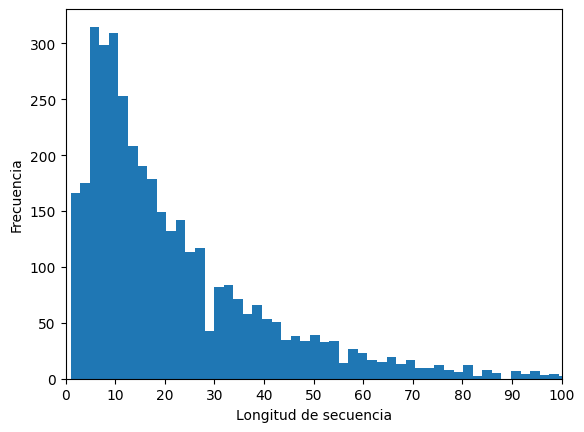

In [ ]:
plt.hist(length_sentences, bins=100)
plt.xlabel('Longitud de secuencia')
plt.ylabel('Frecuencia')
plt.xlim(0, 100)
plt.xticks(range(0, 101, 10))

plt.show()

In [ ]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 49


In [ ]:
# max_context_size = p 0.75
max_context_size = int(np.percentile(length_sentences, 75)-1)
print(f'max_context_size: {max_context_size}')

max_context_size: 29


In [ ]:
# Elimino registros que quedaron vacios
print(len(segmented_sentences))
segmented_sentences = [sentence for sentence in segmented_sentences if len(sentence) > 0]

print(len(segmented_sentences))

3747
3747


###  Tokenizar

In [ ]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [ ]:
tokenized_sentences[0]

[1091, 35, 3253, 3254, 3255]

In [ ]:
segmented_sentences[0]

['persuasion', 'by', 'jane', 'austen', '1818']

### Organizando y estructurando el dataset

In [ ]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.15, random_state=42)

In [ ]:
len(tokenized_sentences_train)

3184

In [ ]:
len(tokenized_sentences_val)

563

Split de las oraciones que tienen tamaño mayor al contexto máximo, para generar más secuencias de entrenamiento.

In [ ]:
from keras.preprocessing.sequence import pad_sequences

tok_sent = []

for sent in tokenized_sentences_train:
    # si la secuencia tiene más términos que el tamaño de contexto máximo,
    # armo varias sub-secuencias de tamaño máximo
    if len(sent) > (max_context_size + 1):
        extra = len(sent) - (max_context_size + 1) + 1
        for i in range(extra):
            tok_sent.append(sent[i:i + max_context_size + 1])
    else:  # si la secuencia tiene menos términos el tamaño de contexto máximo, aplico padding pre
        # Rellenamos la secuencia al tamaño de contexto máximo con padding 'pre'
        padded_sent = pad_sequences([sent], maxlen=max_context_size + 1, padding='pre', truncating='pre')
        tok_sent.append(padded_sent[0])

len(tok_sent)

20074

In [ ]:
tok_sent_augm = []


for sent in tok_sent:
    # Si 'sent' es ya de longitud 31, simplemente la agregamos
    if len(sent) == max_context_size+1:
        tok_sent_augm.append(sent)

# Convertimos la lista de oraciones a un arreglo de numpy
train_seqs = np.array(tok_sent_augm)


print(train_seqs.shape)

(20074, 30)


In [ ]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [ ]:
y.shape

(20074, 29)

In [ ]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'to',
 3: 'and',
 4: 'of',
 5: 'a',
 6: 'in',
 7: 'was',
 8: 'her',
 9: 'had',
 10: 'she',
 11: 'i',
 12: 'it',
 13: 'he',
 14: 'be',
 15: 'not',
 16: 'that',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'his',
 21: 'with',
 22: 'you',
 23: 'have',
 24: "'",
 25: 'at',
 26: 'all',
 27: 'anne',
 28: 'been',
 29: 's',
 30: 'him',
 31: 'could',
 32: 'very',
 33: 'they',
 34: 'were',
 35: 'by',
 36: 'which',
 37: 'is',
 38: 'on',
 39: 'so',
 40: 'no',
 41: 'would',
 42: 'captain',
 43: 'from',
 44: 'their',
 45: 'mrs',
 46: 'elliot',
 47: 'there',
 48: 'or',
 49: 'more',
 50: 'them',
 51: 'mr',
 52: 'this',
 53: 'an',
 54: 'than',
 55: 'one',
 56: 'must',
 57: 'when',
 58: 'my',
 59: 'being',
 60: 'only',
 61: 'wentworth',
 62: 'lady',
 63: 'such',
 64: 'do',
 65: 'much',
 66: 'if',
 67: 'any',
 68: 'what',
 69: 'who',
 70: 'should',
 71: 'me',
 72: 'good',
 73: 'little',
 74: 'said',
 75: 'will',
 76: 'charles',
 77: 'might',
 78: 'own',
 79: 'well',
 80: 'did',
 81: 'herself',


In [ ]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

5778

In [ ]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'to': 2, 'and': 3, 'of': 4, 'a': 5, 'in': 6, 'was': 7, 'her': 8, 'had': 9, 'she': 10, 'i': 11, 'it': 12, 'he': 13, 'be': 14, 'not': 15, 'that': 16, 'as': 17, 'for': 18, 'but': 19, 'his': 20, 'with': 21, 'you': 22, 'have': 23, "'": 24, 'at': 25, 'all': 26, 'anne': 27, 'been': 28, 's': 29, 'him': 30, 'could': 31, 'very': 32, 'they': 33, 'were': 34, 'by': 35, 'which': 36, 'is': 37, 'on': 38, 'so': 39, 'no': 40, 'would': 41, 'captain': 42, 'from': 43, 'their': 44, 'mrs': 45, 'elliot': 46, 'there': 47, 'or': 48, 'more': 49, 'them': 50, 'mr': 51, 'this': 52, 'an': 53, 'than': 54, 'one': 55, 'must': 56, 'when': 57, 'my': 58, 'being': 59, 'only': 60, 'wentworth': 61, 'lady': 62, 'such': 63, 'do': 64, 'much': 65, 'if': 66, 'any': 67, 'what': 68, 'who': 69, 'should': 70, 'me': 71, 'good': 72, 'little': 73, 'said': 74, 'will': 75, 'charles': 76, 'might': 77, 'own': 78, 'well': 79, 'did': 80, 'herself': 81, 'now': 82, 'never': 83, 'we': 84, 'time': 85, 'sir': 86, 'think': 87, 'russell':

In [ ]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'austen': 1, 'persuasion': 6, 'jane': 1, 'by': 359, '1818': 1, '1': 3, 'chapter': 24, 'contemplating': 1, 'turned': 21, 'century': 1, 'baronetage': 2, 'took': 19, 'man': 124, 'and': 1567, 'creations': 2, 'a': 1149, 'last': 86, 'book': 8, 'interest': 43, 'unwelcome': 3, 'contempt': 5, 'idle': 3, 'walter': 133, 'patents': 1, 'the': 1643, 'were': 380, 'affairs': 8, 'with': 571, 'consolation': 3, 'which': 364, 'somersetshire': 4, 'earliest': 4, 'was': 1036, 'pity': 13, 'occupation': 5, 'distressed': 6, 'faculties': 1, 'respect': 17, 'in': 1024, 'never': 144, 'kellynch': 70, 'other': 139, 'if': 194, 'every': 94, 'naturally': 6, 'history': 16, 'of': 1470, 'up': 88, 'domestic': 11, 'leaf': 1, 'sir': 141, 'found': 81, 'arising': 2, 'over': 82, 'hour': 32, 'own': 147, 'any': 177, 'could': 412, 'one': 220, 'who': 174, 'failed': 5, 'an': 228, 'sensations': 9, 'he': 677, 'limited': 2, 'his': 473, 'roused': 8, 'hall': 28, 'read': 13, 'remnant': 1, 'for': 601, 'as': 563, 


### Definir el modelo

In [ ]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=30, input_shape=(max_context_size,)))

model.add((LSTM(100, return_sequences=True)))
model.add((LSTM(50, return_sequences=True)))

model.add(Dense(vocab_size+1, activation='softmax'))


#optimizador = Adam(learning_rate=0.001)
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='adam')

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 29, 30)              │         173,370 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 29, 100)             │          52,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 29, 50)              │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 29, 5779)            │         294,729 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,699 (2.10 MB)

 Trainable params: 550,699 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=10 ,max_val_size=2500):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)

      # Limitar `self.padded` a un máximo de observaciones
      if len(self.padded) > max_val_size:
          self.padded = self.padded[:max_val_size]
          self.target = self.target[:max_val_size]
          self.info = self.info[:max_val_size]


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model2.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento

In [ ]:
# Entrenamos el modelo
history_ppl = []
hist = model.fit(X, y, epochs=20,callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=16)

Epoch 1/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4412
 mean perplexity: 3599.624878134552 

Saved new model!
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 6.4410
Epoch 2/20
1252/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0622
 mean perplexity: 6154.249442425538 

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 6.0622
Epoch 3/20
1248/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0686
 mean perplexity: 7179.095254230632 

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 6.0686
Epoch 4/20
1255/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0051
 mean perplexity: 108114.47812964262 

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 6.0049
Epoch 5/20
1252/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2699
 mean perplexity: 280719.92850396415 

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 5.2696
Epoch 6/20
1249/1255 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9355
 mean perplexity: 85869.38602754564 

1255/1255 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms

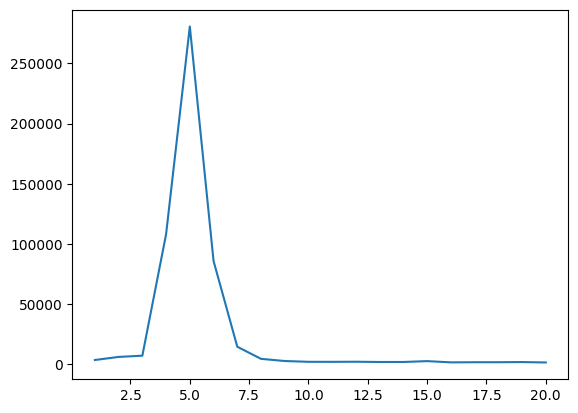

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

La gráfica muestra que el modelo inicialmente tiene dificultades de aprendizaje, alcanzando valores muy altos de perplejidad en las primeras epocas. Sin embargo, a medida que avanza el entrenamiento, el modelo mejora significativamente su capacidad de predicción, reduciendo la perplejidad hacia el final del proceso.

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model2.keras')


### Predicción de próxima palabra

In [ ]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://dbc558cf306e887197.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://dbc558cf306e887197.gradio.live


### Generación de secuencias

In [ ]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [ ]:

input_text='Her eyes were fixed on'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'Her eyes were fixed on her own complaints and not a very man of it'

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens


In [ ]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="Her eyes were fixed on",temp=1,mode='sto')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 35)

In [ ]:
# veamos las salidas
decode(salidas[0])

['her eyes were fixed on one others and to be called']

In [ ]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="Her eyes were fixed on",temp=1,mode='det')

In [ ]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 35)

In [ ]:
# veamos las salidas
decode(salidas[0])

["her eyes were fixed on mr elliot ' s being the"]

Se llega a un buen resultado cuando se intenta predecir la siguiente palabra.

Oración de prueba -> 'Her eyes were fixed on'
Predicción -> 'her'

Lo cual tiene sentido semántico.

No obstante, cuando se trata de predecir secuencias más largas, el modelo parece tener más dificultades y perder el sentido hacia el final de la oración.

Si bien el modelo hace una buena predicción a nivel de palabras individuales, tiene dificultades en mantener la coherencia y el significado cuando se trata de generar predicciones más extensas.

